In [2]:
# !pip install polars umap-learn

In [3]:
import os
import warnings
import pickle
from tqdm.notebook import tqdm
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
from umap import UMAP
from sknetwork.clustering import Leiden
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

from src.helpers.sentiment_analysis import SentimentModel
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding

In [4]:
warnings.filterwarnings("ignore")

DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.getenv("OUTPUTS_PATH")

DEVICE = torch.device("mps")
RANDOM_STATE = 42

EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

# Loading NRC-VAD Lexicon data and getting embeddings

In [5]:
version = "v2.1" # "v1.0" or "v2.1"
fbase = "NRC-VAD-Lexicon-" + version
df = pl.read_csv(os.path.join(DATA_PATH, fbase, fbase+".txt"), separator="\t")

In [6]:
df

shape: (54_801, 4)
┌────────────┬─────────┬─────────┬───────────┐
│ term       ┆ valence ┆ arousal ┆ dominance │
│ ---        ┆ ---     ┆ ---     ┆ ---       │
│ str        ┆ f64     ┆ f64     ┆ f64       │
╞════════════╪═════════╪═════════╪═══════════╡
│ a battery  ┆ 0.134   ┆ -0.298  ┆ -0.096    │
│ a bit      ┆ -0.096  ┆ -0.264  ┆ -0.214    │
│ a bunch    ┆ 0.088   ┆ -0.35   ┆ -0.068    │
│ a cappella ┆ 0.134   ┆ -0.116  ┆ -0.2      │
│ a couple   ┆ 0.266   ┆ -0.11   ┆ 0.09      │
│ …          ┆ …       ┆ …       ┆ …         │
│ zorro      ┆ 0.625   ┆ 0.667   ┆ 0.792     │
│ zucchini   ┆ 0.02    ┆ -0.358  ┆ -0.5      │
│ zulu       ┆ 0.0     ┆ 0.0     ┆ 0.0       │
│ zygote     ┆ 0.278   ┆ 0.333   ┆ -0.167    │
│ zygotic    ┆ 0.0     ┆ -0.5    ┆ 0.0       │
└────────────┴─────────┴─────────┴───────────┘

In [7]:
fpath = os.path.join(DATA_PATH, fbase, f"embeddings.pkl")
if os.path.exists(fpath):
    print(f"Loading data with embeddings from '{fpath}'...")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"!!! Loaded {len(embeddings)} embeddings from '{fpath}' !!!")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["term"].to_list(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"!!! Saved {len(embeddings)} embeddings to '{fpath}' !!!")

del fpath

Loading data with embeddings from '/Users/tig1/Programming/TOPOL/data/NRC-VAD-Lexicon-v2.1/embeddings.pkl'...
!!! Loaded 54801 embeddings from '/Users/tig1/Programming/TOPOL/data/NRC-VAD-Lexicon-v2.1/embeddings.pkl' !!!


In [8]:
df = df.with_columns(
    pl.Series("embedding", embeddings, dtype=pl.List(pl.Float64))
)

# Adding sentiment score

(Not worth it, better use valence)

In [9]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE, n_special_tokens=0)

fpath = os.path.join(DATA_PATH, fbase, "distillbert_sentiments.pkl")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    # sentiments = [sentiment_model(text, truncation=False) for text in df["term"].to_list()]
    sentiments = []
    for text in tqdm(df["term"].to_list(), desc="Generating sentiments"):
        sentiments.append(sentiment_model(text, truncation=False))
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

del fpath

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/NRC-VAD-Lexicon-v2.1/distillbert_sentiments.pkl
Loaded 54801 sentiments


In [10]:
sentiment_scores = [sentiment_model.get_sentiment_score(sentiment) for sentiment in sentiments]
df = df.with_columns(
    pl.Series("sentiment", sentiment_scores, dtype=pl.Float64)
)
del sentiment_model
df = df [["term", "valence", "arousal", "dominance", "sentiment", "embedding"]]

In [11]:
output_path = os.path.join(DATA_PATH, fbase, f"nrc_vad_lexicon_{version}.pkl")
df.to_pandas().to_pickle(output_path)
# with open(output_path, "wb") as f:
#     pickle.dump(df.to_numpy(), f)

# Lexicon clustering

### Dimensionality reduction

In [ ]:
umap = UMAP(
    n_neighbors=15,
    min_dist=0.2,
    n_components=3,
    metric="cosine",
    random_state=RANDOM_STATE,
    verbose=False,
)
umap_embeddings = umap.fit_transform(embeddings)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
df = df.with_columns(
    pl.Series("reduced_embedding", umap_embeddings, dtype=pl.List(pl.Float64))
)

### Clustering

In [ ]:
leiden = Leiden(
    resolution=1.0,
    modularity='dugue',
    random_state=RANDOM_STATE,
    verbose=False,
)
graph = umap.graph_
labels = leiden.fit_predict(graph)

print(f"Found {len(set(labels))} clusters")

Found 83 clusters


In [ ]:
df = df.with_columns(
    pl.Series("labels", labels, dtype=pl.Int32)
)

### Vizualize results

In [ ]:
fig = go.Figure()

for label in set(labels):
    cluster_df = df.filter(pl.col("labels") == label)
    x = [embedding[0] for embedding in cluster_df["reduced_embedding"]]
    y = [embedding[1] for embedding in cluster_df["reduced_embedding"]]
    z = [embedding[2] for embedding in cluster_df["reduced_embedding"]]
    
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=5),
        name=f"Cluster {label}"
    ))

fig.update_layout(
    title="NRC VAD Lexicon Clusters",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600,
    margin=dict(l=0, r=0, b=0, t=30),
    # legend=dict(x=0, y=1, traceorder='normal', orientation='h')
)

fig.show()


# VAD scores decomposition

In [ ]:
vad_scores = df[["valence", "arousal", "dominance"]].to_numpy()
n_components = 3

### PCA

In [ ]:
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
pca_vad_scores = pca.fit_transform(vad_scores)

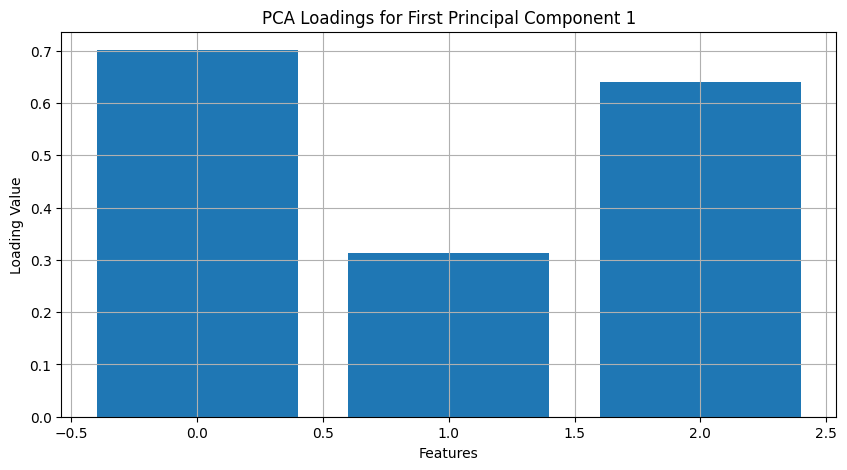

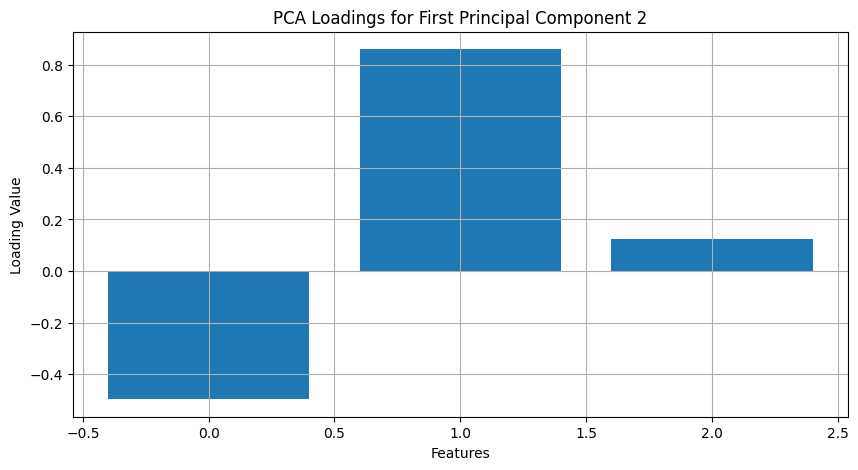

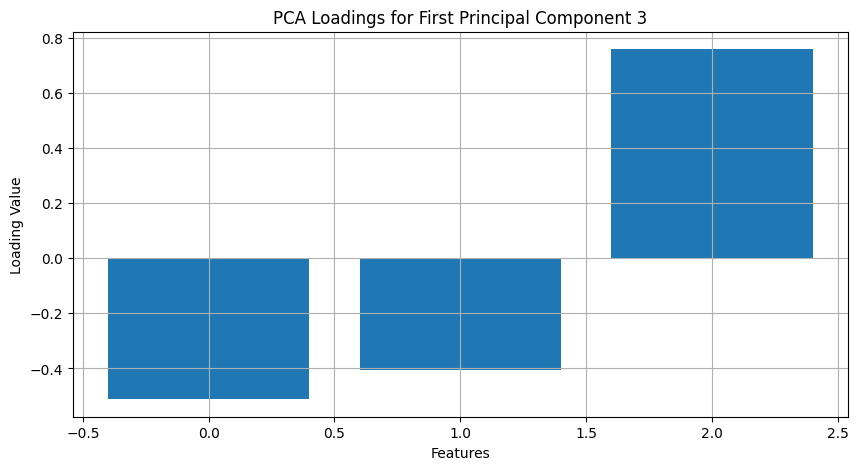

In [ ]:
# Plot PCA loadings
for component in range(pca.n_components_):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(pca.components_[component])), pca.components_[component])
    plt.title('PCA Loadings for First Principal Component {}'.format(component + 1))
    plt.xlabel('Features')
    plt.ylabel('Loading Value')
    plt.grid()
    plt.show()

### Factor model

In [ ]:
fm = FactorAnalysis(n_components=n_components, random_state=RANDOM_STATE)
fa_vad_scores = fm.fit_transform(vad_scores)

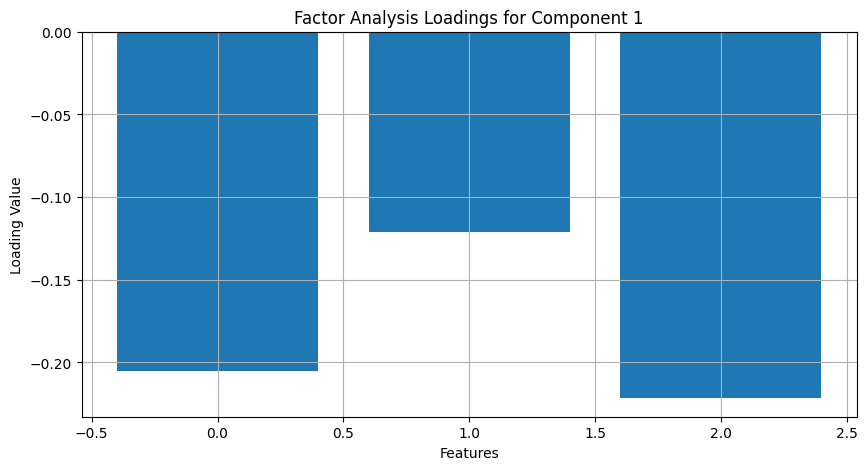

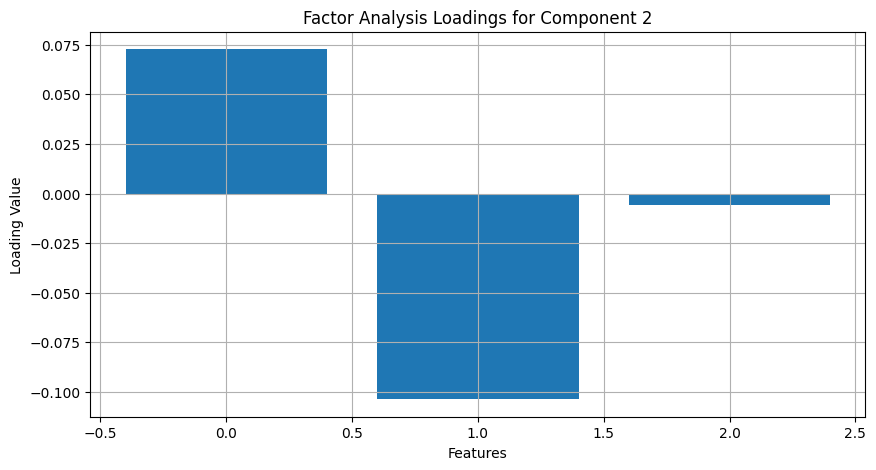

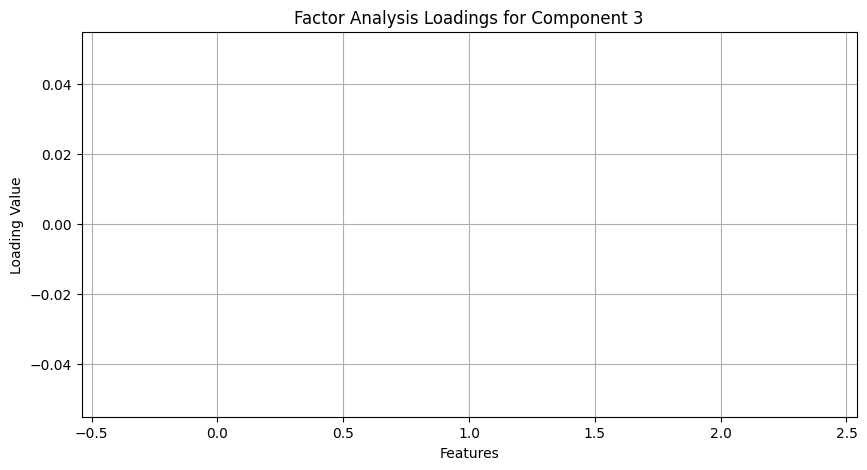

In [ ]:
# Vizualize Factor Analysis loadings
for component in range(fm.n_components):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(fm.components_[component])), fm.components_[component])
    plt.title('Factor Analysis Loadings for Component {}'.format(component + 1))
    plt.xlabel('Features')
    plt.ylabel('Loading Value')
    plt.grid()
    plt.show()